<a href="https://colab.research.google.com/github/ranna-waleed/DSAI-305_Loan-Default-Prediction/blob/main/ROAA_DSAI305_Project_MODEL_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on the paper  https://arxiv.org/pdf/2012.03749

 I'll implement the XGBoost model (which showed top performance) along with 4 explainability techniques:

`final_loan_data_leakproof.csv` - The main dataset with selected features from the EDA noteboook

`engineered_loan_data_leakproof.pkl `- Engineered features (if needed)

`processed_loan_data.pkl` - Fully processed data (if needed)

# IMPORTS

In [ ]:
!pip install lime
!pip install pdpbox

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import lime
import lime.lime_tabular
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
final_df = pd.read_csv('final_loan_data_leakproof.csv')

In [ ]:
print("Shape:", final_df.shape)
print("Columns:", final_df.columns.tolist())

Shape: (50000, 17)
Columns: ['addr_state_MI', 'verification_status_Verified', 'home_ownership_RENT', 'loan_status_Fully Paid', 'sub_grade', 'dti_ratio', 'issue_d_year', 'dti', 'int_rate', 'grade', 'term_ 60 months', 'loan_to_income', 'home_ownership_MORTGAGE', 'debt_settlement_flag_Y', 'issue_d_month', 'credit_history_years', 'target']


In [ ]:
X = final_df.drop(columns=['target', 'loan_status_Fully Paid', 'debt_settlement_flag_Y'])
y = final_df['target']

In [ ]:
# convert boolean columns to int
bool_columns = X.select_dtypes(include=['bool']).columns
for col in bool_columns:
    X[col] = X[col].astype(int)

In [ ]:
# y is integer (binary: 0 or 1)
if not np.issubdtype(y.dtype, np.integer):
    y = y.astype(np.int64)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Convert to numpy arrays
X_train = X_train.values.astype(np.float32)  #  float for features
X_test = X_test.values.astype(np.float32)

y_train = y_train.values.astype(np.int64)     # int for labels
y_test = y_test.values.astype(np.int64)

# MODEL

In [ ]:
 # Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=len(y_train[y_train == 0])/len(y_train[y_train == 1])  # give weights for class imbalance
)

In [ ]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Default (0)', 'Default (1)']))

Classification Report:
                 precision    recall  f1-score   support

Non-Default (0)       0.88      0.67      0.76      7977
    Default (1)       0.33      0.64      0.44      2023

       accuracy                           0.67     10000
      macro avg       0.61      0.66      0.60     10000
   weighted avg       0.77      0.67      0.70     10000



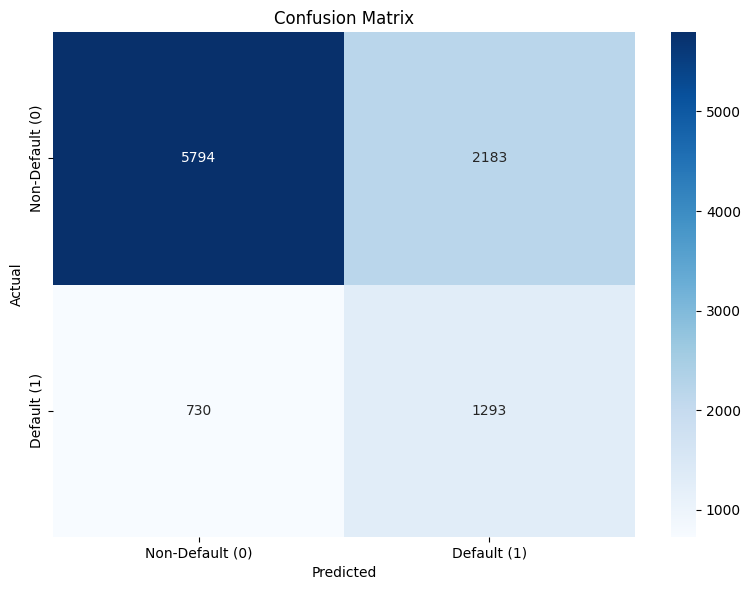

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Default (0)', 'Default (1)'],
            yticklabels=['Non-Default (0)', 'Default (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Explainability technique 1: feature importance

In [ ]:
feature_names = final_df.drop(columns=['target','debt_settlement_flag_Y', 'loan_status_Fully Paid']).columns.tolist()

feature_importance = xgb_model.get_booster().get_score(importance_type='gain') # feature importance using gain

importance_dict = {}
for k, v in feature_importance.items():
    if k.startswith('f'):
        idx = int(k[1:])
        importance_dict[feature_names[idx]] = v


sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))  # sort by importance Most --> least

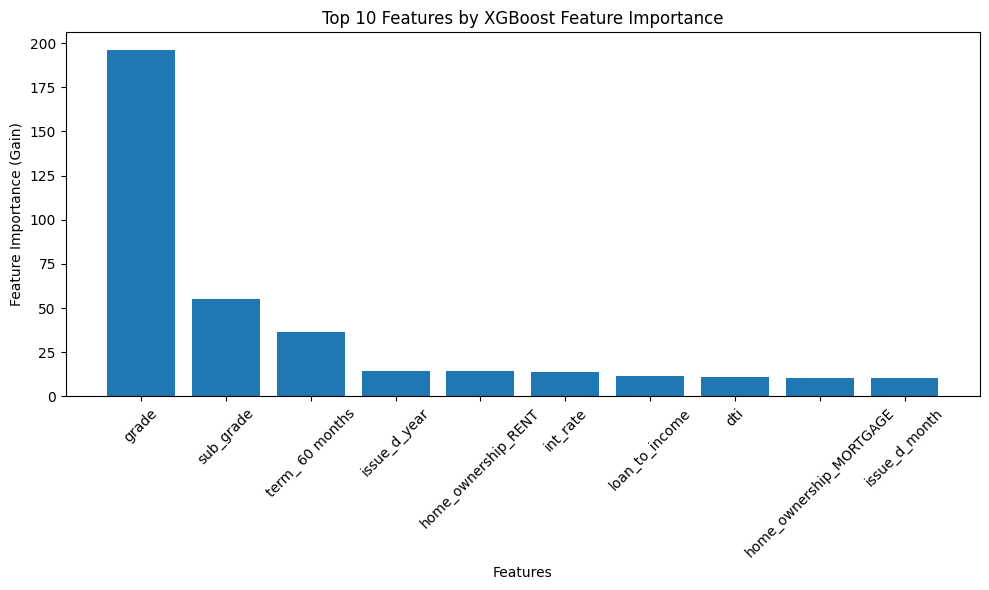

In [ ]:
N = 10  #  top N features

plt.figure(figsize=(10, 6))
plt.bar(list(sorted_importance.keys())[:N], list(sorted_importance.values())[:N])
plt.xticks(rotation=45)

plt.xlabel("Features")
plt.ylabel("Feature Importance (Gain)")
plt.title(f"Top {N} Features by XGBoost Feature Importance")

plt.tight_layout()
plt.show()

# Explainability Technique 2: shap


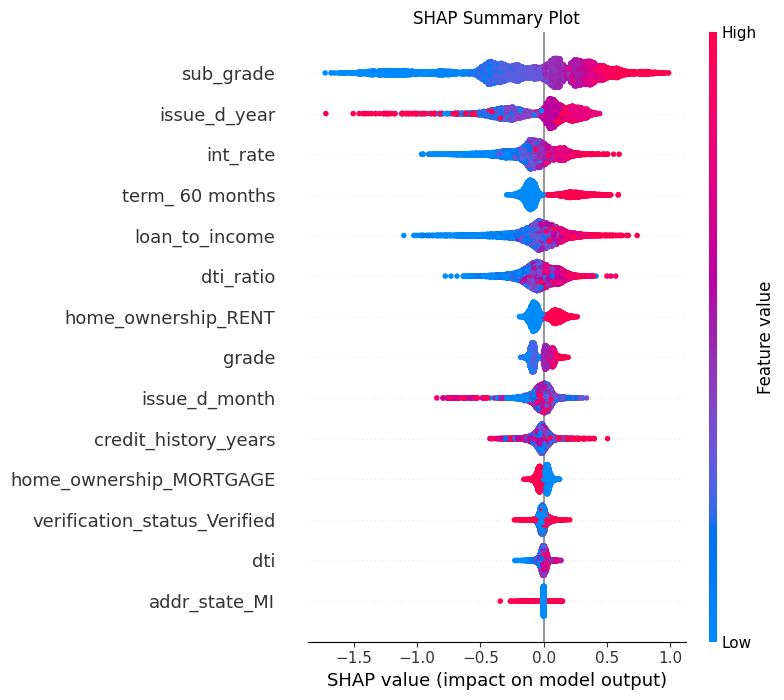

In [ ]:
# 1. SHAP Explainability

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()
plt.savefig('shap_summary_plot.png')
plt.close()

sub_grade as the most influential feature, with worse grades and higher values of int_rate, term_60_months, and loan_to_income increasing default risk, while better grades and lower values decrease it.

# Explainability Technique 3: PDP

In [ ]:
N = 10  #  top features based on mean absolute SHAP values

# feature importance based on SHAP values
feature_importance = np.abs(shap_values).mean(0)
top_feature_indices = feature_importance.argsort()[-N:][::-1]
top_features = [feature_names[idx] for idx in top_feature_indices]

print(f"Top {N} features: {top_features}")

In [ ]:
binary_features = ['term_ 60 months', 'home_ownership_RENT', 'verification_status_Verified']
all_features = feature_names
non_binary_features = [f for f in top_features if f not in binary_features and f in all_features]

non_binary_features = [f for f in non_binary_features if f in feature_names]

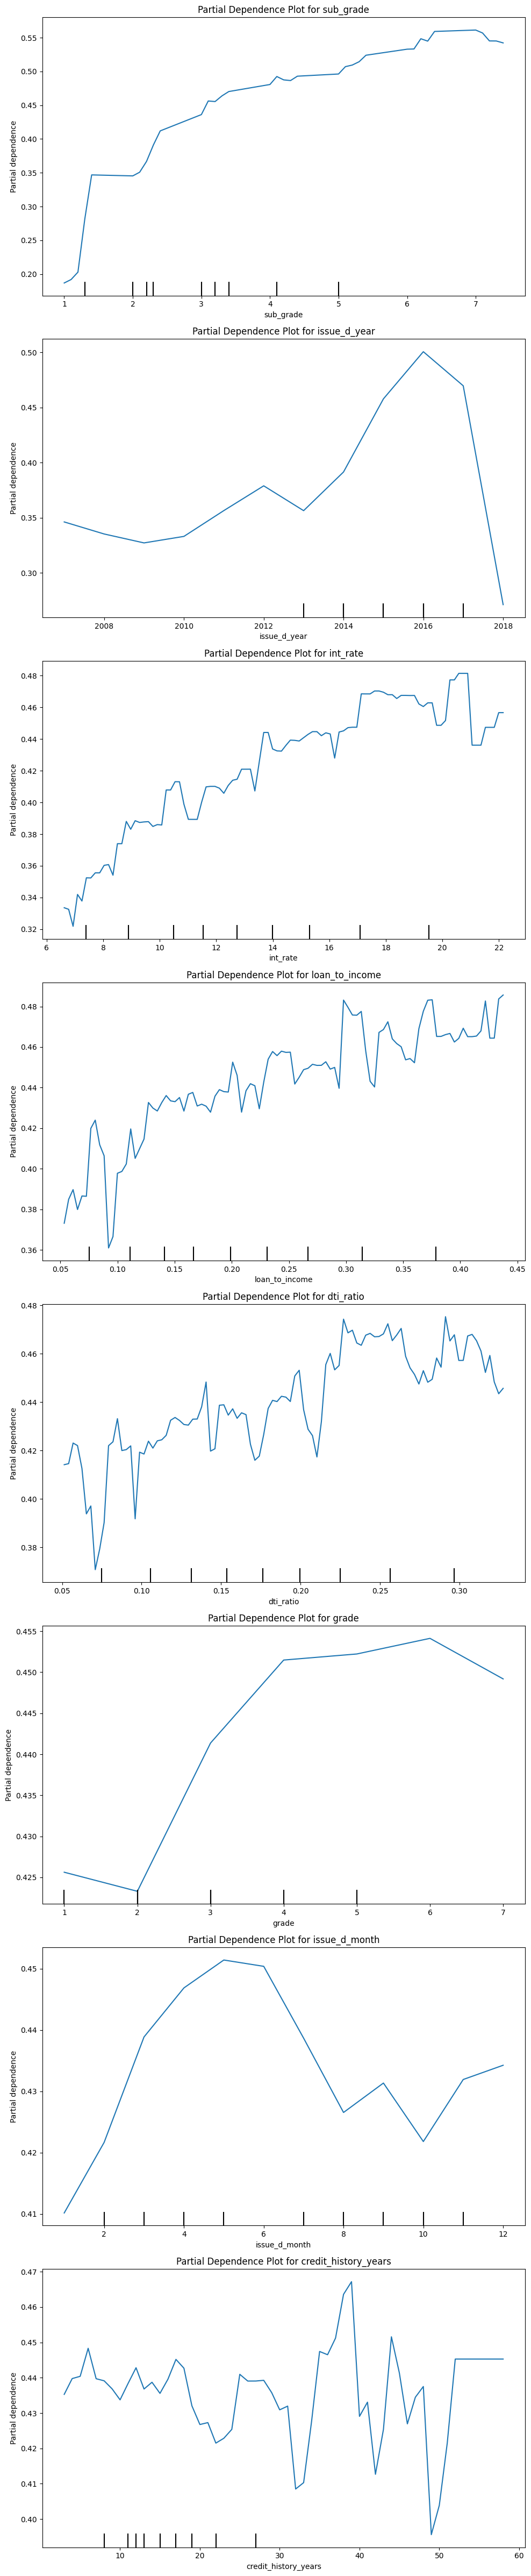

In [ ]:
# pdp for non-binary features

n_non_binary = len(non_binary_features)

if n_non_binary > 0:
    fig, axes = plt.subplots(n_non_binary, 1, figsize=(10, 6 * n_non_binary), sharex=False)

    for idx, feature_name in enumerate(non_binary_features):
        feature_idx = feature_names.index(feature_name)
        PartialDependenceDisplay.from_estimator(
                estimator=xgb_model,
                X=X_test,
                features=[feature_idx],
                feature_names=feature_names,
                ax=axes[idx],
                grid_resolution=100,
                kind='average',
                response_method='predict_proba',
                target=1  # prop of default (class 1)
            )
        axes[idx].set_title(f"Partial Dependence Plot for {feature_name}")


    plt.tight_layout()
    plt.savefig('pdp_plots_non_binary_features.png')
    plt.show()
    plt.close()

else:
    print("no non-binary features to plot pdp for")

the observed Fluctuations: indicate interactions with other features that pdp don’t capture (because pdp assume feature independence and some of the features here are dependent )


* Strong Effects: sub_grade, grade, and int_rate are the most influential, with worse grades and higher rates significantly increasing default risk.

* Moderate Effects: loan_to_income and dti_ratio show a general increase in risk with higher values.

* issue_d_year reveals higher risk for loans issued around 2014-2016

* credit_history_years shows no consistent trend, suggesting it’s less critical.


# Explainability Technique 4: LIME

In [ ]:
# 3. LIME Explainability

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=['Non-Default', 'Default'],
    mode='classification'
)

In [ ]:
# Explain a single instance (first test instance)

instance_idx = 23


lime_exp = lime_explainer.explain_instance(
    data_row=X_test[instance_idx],
    predict_fn=xgb_model.predict_proba,
    num_features=10
)

<Figure size 1000x600 with 0 Axes>

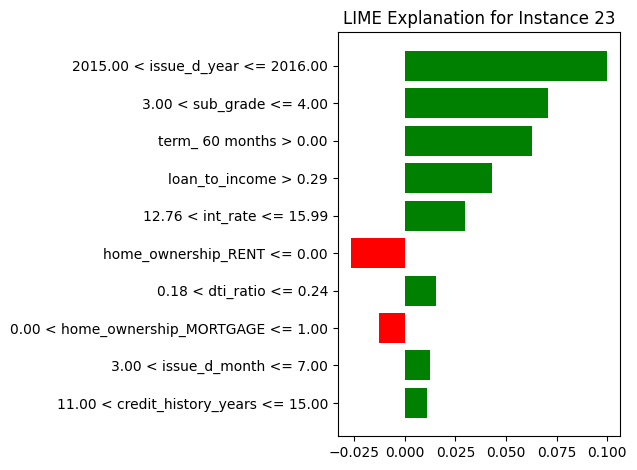

In [ ]:
# Save LIME explanation plot

plt.figure(figsize=(10, 6))
lime_exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {instance_idx}")
plt.tight_layout()
plt.show()
plt.savefig('lime_explanation.png')
plt.close()

red bars : features that increase the likelihood of default (class 1).

green bars : features that decrease the likelihood of default, supporting the non-default prediction (class 0).

